<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/CVRPTW_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza Soroudi
alireza.soroudi@gmail.com

Linkedin News letter : https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/

Git hub: https://github.com/OptimizationExpert/Pyomo

In [2]:
import pandas as pd
!pip install ortools
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt # Data visualization
import random
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.3 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.2

{1: (0.5, 0.5, 0),
 2: (0.2637249748978515, 0.699470145311395, 3),
 3: (0.09557895552666551, 0.11715338363893013, 2),
 4: (0.3090717312955156, 0.6427179881474836, 11),
 5: (0.6773383647441461, 0.07102703888920436, 18),
 6: (0.43835710249870263, 0.8635790057422129, 5),
 7: (0.6707329765124868, 0.21098206116465557, 11),
 8: (0.8453490547687463, 0.6112964333674696, 18),
 9: (0.17254203407084712, 0.06258433105797978, 3),
 10: (0.12856926849055517, 0.9709031049782285, 12),
 11: (0.1533198998225087, 0.31726275930599135, 19),
 12: (0.8976365971924717, 0.33706811897232114, 19),
 13: (0.06028108203578564, 0.3522483971146093, 13),
 14: (0.5446762478176591, 0.9147830494910836, 12),
 15: (0.10505100288719371, 0.9173872116716835, 4),
 16: (0.8573607241105781, 0.9782621227390597, 8),
 17: (0.7957230222292813, 0.9021251115183048, 7),
 18: (0.4458764010252293, 0.6942128838719435, 16),
 19: (0.39385065164693234, 0.5471391794461979, 5),
 20: (0.014853194676043846, 0.27153093660391125, 15),
 21: (0.30760

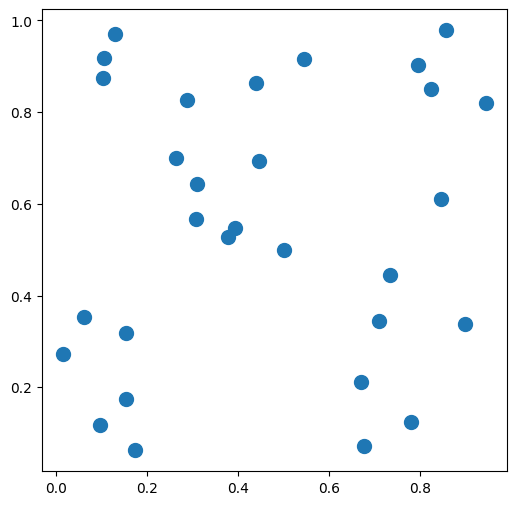

In [3]:
n = 30
depot = 1
nodes = [i for i in range(1,1+n)]
data = {}
for n in nodes:
  data[n]=(random.random(),random.random(), random.randint(1,20))
data[depot]=(0.5, 0.5,0)
cars = range(4)
plt.figure(figsize=(6,6))
X= [data[n][0] for n in nodes]
Y= [data[n][1] for n in nodes]
plt.scatter(X,Y,s=100)
data

In [31]:
def distance(n:int,m:int,data:dict)-> int:
  x1,y1 = data[n][0],data[n][1]
  x2,y2 = data[m][0],data[m][1]
  return int(100*np.sqrt( (x1-x2)**2+(y1-y2)**2))

distance(1,2,data)

check = sum(data[n][2] for n in nodes)

KOLORS = ['r','k','b','g']


window = {}

for i in nodes:
  st = 60*random.randint(5,9)
  L = 30*random.randint(2,5)
  st2 = 60*random.randint(12,17)
  L2 = 30*random.randint(3,6)
  window[i]= {'w1':(st,st+L), 'w2':(st2,st2+L2)}

window

{1: {'w1': (360, 450), 'w2': (780, 930)},
 2: {'w1': (480, 570), 'w2': (780, 960)},
 3: {'w1': (360, 480), 'w2': (900, 1050)},
 4: {'w1': (480, 540), 'w2': (780, 870)},
 5: {'w1': (420, 510), 'w2': (960, 1110)},
 6: {'w1': (420, 540), 'w2': (960, 1050)},
 7: {'w1': (420, 480), 'w2': (900, 1080)},
 8: {'w1': (480, 630), 'w2': (840, 960)},
 9: {'w1': (420, 540), 'w2': (780, 930)},
 10: {'w1': (300, 360), 'w2': (840, 990)},
 11: {'w1': (420, 510), 'w2': (900, 1080)},
 12: {'w1': (420, 510), 'w2': (1020, 1140)},
 13: {'w1': (540, 600), 'w2': (840, 930)},
 14: {'w1': (360, 420), 'w2': (1020, 1200)},
 15: {'w1': (540, 600), 'w2': (780, 930)},
 16: {'w1': (300, 360), 'w2': (780, 900)},
 17: {'w1': (300, 390), 'w2': (960, 1080)},
 18: {'w1': (360, 450), 'w2': (780, 960)},
 19: {'w1': (480, 630), 'w2': (840, 1020)},
 20: {'w1': (300, 450), 'w2': (1020, 1170)},
 21: {'w1': (360, 510), 'w2': (960, 1140)},
 22: {'w1': (420, 480), 'w2': (780, 930)},
 23: {'w1': (540, 690), 'w2': (840, 990)},
 24: {

Min of objective function: 750.0

TAG900 1 1500
TAG900 2 873
TAG900 3 900
TAG900 4 492
TAG900 5 1060
TAG900 6 420
TAG900 7 981
TAG900 8 620
TAG900 9 909
TAG900 10 840
TAG900 11 1034
TAG900 12 1025
TAG900 13 913
TAG900 14 384
TAG900 15 540
TAG900 16 780
TAG900 17 960
TAG900 18 360
TAG900 19 480
TAG900 20 1020
TAG900 21 1063
TAG900 22 464
TAG900 23 977
TAG900 24 840
TAG900 25 1020
TAG900 26 1049
TAG900 27 861
TAG900 28 420
TAG900 29 1030
TAG900 30 965
1 0
1 1
1 2
2 1
3 0
4 0
5 2
6 1
7 0
8 2
9 0
10 1
11 1
12 2
13 1
14 1
15 2
16 2
17 2
18 1
19 0
20 1
21 1
22 2
23 2
24 0
25 0
26 2
27 1
28 2
29 0
30 2


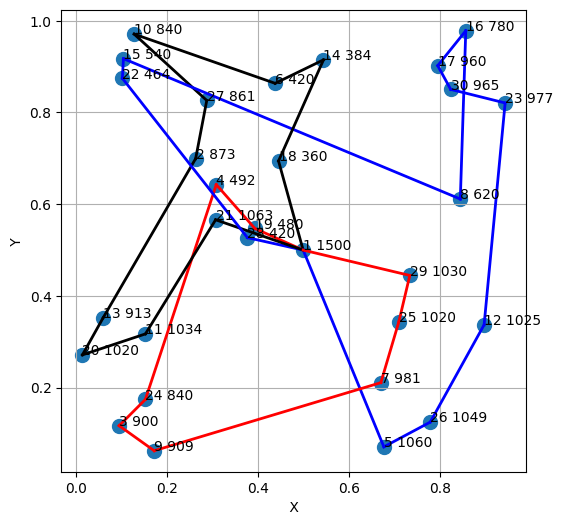

In [34]:
def main() -> None:
    # Creates the model.
    cap = {0:120, 1:190, 2:150, 3:170}
    possible_windpws = ['w1','w2']
    model = cp_model.CpModel()
    x={(i,j,c):model.NewBoolVar(f"flow_{i}_{j}_{c}") for i in nodes
       for j in nodes for c in cars if i!=j}
    assign = {(i,c): model.NewBoolVar(f"assign_{i}_{c}") for i in nodes for c in cars}
    used_car = {c: model.NewBoolVar(f"used_{c}") for c in cars}
    arrive = {i: model.NewIntVar(0,1500,f"assign_{i}") for i in nodes}
    assign_window = {(i,w): model.NewBoolVar(f"window_{i}_{w}") for i in nodes for w in possible_windpws}
    start_car = {c: model.NewIntVar(0,1500,f"start_car_{c}") for c in cars}
    for i in nodes:
      expressions = [assign[i,c] for c in cars]
      model.AddAtLeastOne(expressions)

      expr_window= [assign_window[i,w] for w in possible_windpws]
      model.AddExactlyOne(expr_window)
      for w in possible_windpws:
        if i!=depot:
          model.Add(arrive[i]>=window[i][w][0]).OnlyEnforceIf(assign_window[i,w])
          model.Add(arrive[i]<=window[i][w][1]).OnlyEnforceIf(assign_window[i,w])


    for (i,c),v in assign.items():
      model.Add(v<=used_car[c])

    for (i,j,c),v in x.items():
      if i!=depot:
        model.Add(arrive[j]>=arrive[i]+distance(i,j,data) ).OnlyEnforceIf(v)
      else:
        model.Add(arrive[j]>=start_car[c]+distance(i,j,data) ).OnlyEnforceIf(v)

    for c in cars:
      model.Add(assign[depot,c]==used_car[c])
      arcs= [ (i,j,v) for (i,j,cc),v in x.items() if cc == c] + [(i,i,assign[i,c].Not()) for i in nodes]
      model.AddCircuit(arcs)

      expressions = [v*data[i][2] for (i,cc),v in assign.items() if c ==cc]
      model.Add(cp_model.LinearExpr.Sum(expressions) <= cap[c])




    expressions_of = [ v for (i,j,c),v in x.items() ]
    coeffs_of = [distance(i,j,data) for (i,j,c),v in x.items() ]

    model.minimize(cp_model.LinearExpr.WeightedSum(expressions_of,coeffs_of))

    # Creates a solver and solves the model.
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 180
    status = solver.solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print(f"Min of objective function: {solver.objective_value}\n")
        plt.figure(figsize=(6,6))
        X= [data[n][0] for n in nodes]
        Y= [data[n][1] for n in nodes]
        plt.scatter(X,Y,s=100)

        for i in nodes:
          print("TAG900",i,solver.Value(arrive[i]))
          plt.text(data[i][0],data[i][1],s=f"{i} "+str(solver.Value(arrive[i])) )

        for (i,c),v in assign.items():
          if solver.value(v)>0:
            print(i,c)

        for (i,j,c),v in x.items():
          if solver.value(v)>0:
              x1,y1 = data[i][0],data[i][1]
              x2,y2 = data[j][0],data[j][1]
              plt.plot([x1,x2],[y1,y2], lw=2, c=KOLORS[c])
              #plt.text(x1,y1,s=str(i))

        plt.xlabel(' X ')
        plt.ylabel(' Y ')
        plt.grid()

    else:
        print("No solution found.")

if __name__ == "__main__":
    main()